# NBA 22-23 Analysis & Classification

In [1]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.set_option('display.max_columns', None)

# Web Scraping & Merging Datasets

In [2]:
url = 'https://www.basketball-reference.com/leagues/NBA_2023_totals.html'
html = urlopen(url)
soup = BeautifulSoup(html, features='lxml')

In [3]:
headers = [th.getText() for th in soup.findAll('tr')[0].findAll('th')]
rows = soup.findAll('tr')[1:]
rows_data = [[td.getText() for td in rows[i].findAll('td')]
                     for i in range(len(rows))]
headers = headers[1:]

In [4]:
nba = pd.DataFrame(rows_data, columns = headers)
nba = nba.mask(nba.eq('None')).dropna()
nba = nba.apply(pd.to_numeric, errors='ignore')

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

mypath='/content/gdrive/MyDrive/'

fn = "NBA_22_23.xlsx"
df2 = pd.read_excel(mypath+fn)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
nba = nba.merge(df2, how='left', left_on='Player', right_on='player')

In [7]:
# Dropping duplicate column 'player' and 'pos'
nba.drop(['player', 'pos'], axis=1, inplace=True)

# Feature Engineering

In [9]:
nba['PPG'] = nba['PTS']/nba['G']
nba['3Ppg'] = nba['3P']/nba['G']
nba['TRBpg'] = nba['TRB']/nba['G']
nba['ASTpg'] = nba['AST']/nba['G']
nba['TSA'] = nba['FGA']+(0.44*nba['FTA'])
nba['TS%'] = nba['PTS']/(2*nba['TSA'])
nba['MPG'] = nba['MP']/nba['G']

In [10]:
# Adjusting decimal displays
nba['PPG'] = nba['PPG'].round(decimals=2)
nba['3Ppg'] = nba['3Ppg'].round(decimals=3)
nba['TRBpg'] = nba['TRBpg'].round(decimals=2)
nba['ASTpg'] = nba['ASTpg'].round(decimals=2)
nba['number'] = nba['number'].round(decimals=0)
nba['TS%'] = nba['TS%'].round(decimals=3)
nba['MPG'] = nba['MPG'].round(decimals=2)

In [11]:
# Converting dtypes
nba['number'] = nba['number'].astype('Int64')
nba['height_feet'] = nba['height_feet'].astype('Int64')
nba['height_inches'] = nba['height_inches'].astype('Int64')
nba['height_in'] = nba['height_in'].astype('Int64')
nba['weight_lbs'] = nba['weight_lbs'].astype('Int64')
nba['birth_day'] = nba['birth_day'].astype('Int64')
nba['birth_year'] = nba['birth_year'].astype('Int64')

In [12]:
# Renaming similarly-named column
nba.rename(columns={"height_in": "total_height_in"}, inplace=True)

In [13]:
nba.head()

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,number,height_feet,height_inches,total_height_in,height_m,weight_lbs,weight_kg,bmi,birth_month,birth_day,birth_year,country,exp,college,PPG,3Ppg,TRBpg,ASTpg,TSA,TS%,MPG
0,Precious Achiuwa,C,23,TOR,12,0,245,36,92,0.391,5,28,0.179,31,64,0.484,0.418,28,33,0.848,24,60,84,16,2,7,15,19,105,5,6,8,80,2.032004,225,102.040816,24.712961,September,19,1999,ng,2,Memphis,8.75,0.417,7.00,1.33,106.52,0.493,20.42
1,Steven Adams,C,29,MEM,25,25,661,90,149,0.604,0,1,0.000,90,148,0.608,0.604,21,67,0.313,120,138,258,57,20,30,52,58,201,4,6,11,83,2.108204,265,120.181406,27.040326,July,20,1993,nz,9,Pitt,8.04,0.000,10.32,2.28,178.48,0.563,26.44
2,Bam Adebayo,C,25,MIA,27,27,944,217,414,0.524,1,10,0.100,216,404,0.535,0.525,122,145,0.841,62,199,261,89,27,19,83,87,557,13,6,9,81,2.057404,255,115.646259,27.320735,July,18,1997,us,5,Kentucky,20.63,0.037,9.67,3.30,477.80,0.583,34.96
3,Ochai Agbaji,SG,22,UTA,12,0,108,14,32,0.438,4,14,0.286,10,18,0.556,0.500,4,7,0.571,6,9,15,1,1,0,0,12,36,30,6,5,77,1.955804,215,97.505669,25.490552,April,20,2000,us,0,Kansas,3.00,0.333,1.25,0.08,35.08,0.513,9.00
4,Santi Aldama,PF,22,MEM,27,16,670,98,206,0.476,37,101,0.366,61,105,0.581,0.566,42,56,0.750,38,115,153,37,23,24,17,68,275,7,6,11,83,2.108204,224,101.587302,22.856728,January,10,2001,es,1,Loyola (MD),10.19,1.370,5.67,1.37,230.64,0.596,24.81


# Data Analysis

## Team Points Per Game

In this analysis, I will extract team points per game using only individual player data. This will be accomplished by grouping the dataframe by team and finding the maximum amount of games played by a player for that team. This should give us the total games played by that team. Note: This assumes that at least one player from each team has played in every game so far this season.
I then divide the team's total points by the games played to get the team's points per game.

In [14]:
# Finding the max games played by a player on each team
team_max_df = nba.groupby(by='Tm').max()
# Finding the total points scored by each team
team_sum_df = nba.groupby(by='Tm').sum()
# Creating a points per game feature for the dataframe
team_sum_df['team_ppg'] = team_sum_df['PTS']/team_max_df['G'].values
# Formatting
team_sum_df['team_ppg'] = team_sum_df['team_ppg'].round(decimals=1)
team_sum_df.reset_index(inplace=True)
# Viewing teams and points per game, sorted
team_sum_df = team_sum_df[['Tm', 'team_ppg']].sort_values(by='team_ppg', ascending=False)
team_sum_df

<ipython-input-14-1e9181892776>:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  team_max_df = nba.groupby(by='Tm').max()


,Tm,team_ppg
20,OKC,119.8
1,BOS,119.4
29,UTA,117.9
0,ATL,117.6
25,SAC,117.6
9,GSW,117.4
18,NOP,117.4
24,POR,116.7
14,MEM,116.5
2,BRK,116.5


## Top 5 Player Statistics

Top 5 player statistics uses a minimum game threshold of over 13 games. At this point in the season, 13 seems to capture active players while weeding out less active players. We don't want players with only a few games played to skew or inflate our results. Additionally, the results below are exactly inline with ESPN's statistics.

### Points Per Game

In [15]:
top_5_ppg = nba[['Player', 'G', 'Tm', 'PPG']]
top_5_ppg[top_5_ppg['G']>17].sort_values('PPG', ascending=False)[:5]

,Player,G,Tm,PPG
130,Joel Embiid,19,PHI,33.26
114,Luka Dončić,26,DAL,32.96
151,Shai Gilgeous-Alexander,26,OKC,31.04
10,Giannis Antetokounmpo,24,MIL,30.58
425,Jayson Tatum,28,BOS,30.18


### Assists

In [16]:
top_5_ast = nba[['Player', 'G', 'Tm', 'ASTpg']]
top_5_ast[top_5_ast['G']>17].sort_values('ASTpg', ascending=False)[:5]

,Player,G,Tm,ASTpg
170,Tyrese Haliburton,27,IND,10.59
487,Trae Young,26,ATL,9.88
226,Nikola Jokić,24,DEN,9.04
114,Luka Dončić,26,DAL,8.65
314,Ja Morant,23,MEM,7.91


### 3 Pointers Made

In [17]:
top_5_3p = nba[['Player', 'G', 'Tm', '3Ppg']]
top_5_3p[top_5_3p['G']>13].sort_values('3Ppg', ascending=False)[:5]

,Player,G,Tm,3Ppg
98,Stephen Curry,26,GSW,5.038
265,Damian Lillard,16,POR,4.500
408,Anfernee Simons,26,POR,4.038
307,Donovan Mitchell,25,CLE,3.880
430,Klay Thompson,23,GSW,3.826


### Rebounds

In [18]:
top_5_reb = nba[['Player', 'G', 'Tm', 'TRBpg']]
top_5_reb[top_5_reb['G']>13].sort_values('TRBpg', ascending=False)[:5]

,Player,G,Tm,TRBpg
100,Anthony Davis,24,LAL,12.42
153,Rudy Gobert,26,MIN,12.15
75,Clint Capela,26,ATL,12.00
394,Domantas Sabonis,27,SAC,11.59
10,Giannis Antetokounmpo,24,MIL,11.12


## Free Throw Analysis

I first create a new dataframe, "ft_df" to analyze player free throws. Next, I create a new feature called "points_forgone" which is a measure of free throws made minus free throws attempted. Since every free throw counts for one point each, one missed free throw equals one missed point, or a point forgone.
> All Games qualifier is on pace for at least 125 made free throws

In [19]:
ft_df = nba[['Player', 'FT', 'FTA', 'FT%']]
ft_df['points_forgone'] = ft_df['FTA']-ft_df['FT']

<ipython-input-19-d58a5fc75c51>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ft_df['points_forgone'] = ft_df['FTA']-ft_df['FT']


In [20]:
# A look at the top 5 players by free throw percentage with
# a minimum of 30 free throw attempts.
ft_df[ft_df['FTA']>30].sort_values('FT%', ascending=False)[:5]

,Player,FT,FTA,FT%,points_forgone
286,Garrison Mathews,29,31,0.935,2
151,Shai Gilgeous-Alexander,242,259,0.934,17
6,Grayson Allen,53,57,0.930,4
124,Kevin Durant,190,206,0.922,16
98,Stephen Curry,124,135,0.919,11


In [21]:
ft_df.sort_values('points_forgone', ascending=False)[:5]

,Player,FT,FTA,FT%,points_forgone
10,Giannis Antetokounmpo,182,290,0.628,108
114,Luka Dončić,196,270,0.726,74
314,Ja Morant,152,206,0.738,54
480,Zion Williamson,129,180,0.717,51
352,Mason Plumlee,65,115,0.565,50


In [22]:
ft_df[ft_df['FTA'] > 30]['FT%'].mean()

0.7760754716981133

In [23]:
# Finding the player on each team with the most points scored
for i in nba['Tm'].unique():
  print('*****')
  print('Team:', i)
  print(nba[nba['Tm']==i].sort_values(by='PTS', ascending=False).iloc[0][0], ':',
        nba[nba['Tm']==i].sort_values(by='PTS', ascending=False).iloc[0][28],
        'pts')
print('*****')

*****
Team: TOR
OG Anunoby : 493 pts
*****
Team: MEM
Ja Morant : 635 pts
*****
Team: MIA
Bam Adebayo : 557 pts
*****
Team: UTA
Lauri Markkanen : 628 pts
*****
Team: MIL
Giannis Antetokounmpo : 734 pts
*****
Team: CLE
Donovan Mitchell : 730 pts
*****
Team: NOP
Zion Williamson : 581 pts
*****
Team: MIN
Anthony Edwards : 631 pts
*****
Team: ORL
Franz Wagner : 578 pts
*****
Team: NYK
Julius Randle : 632 pts
*****
Team: WAS
Kristaps Porziņģis : 609 pts
*****
Team: PHO
Devin Booker : 726 pts
*****
Team: DET
Bojan Bogdanović : 611 pts
*****
Team: GSW
Stephen Curry : 779 pts
*****
Team: CHO
Kelly Oubre Jr. : 590 pts
*****
Team: SAS
Keldon Johnson : 547 pts
*****
Team: SAC
De'Aaron Fox : 541 pts
*****
Team: LAC
Paul George : 516 pts
*****
Team: OKC
Shai Gilgeous-Alexander : 807 pts
*****
Team: DAL
Luka Dončić : 857 pts
*****
Team: LAL
Anthony Davis : 675 pts
*****
Team: IND
Tyrese Haliburton : 534 pts
*****
Team: ATL
Trae Young : 697 pts
*****
Team: CHI
DeMar DeRozan : 707 pts
*****
Team: DEN
N

In [24]:
top_player_list = []
for i in nba['Tm'].unique():
  top_player_list.append(nba[nba['Tm']==i].sort_values(by='PTS', ascending=False).iloc[0][0])

In [25]:
# This query returns a dataframe of the top player for each team (PTS)
top_player_df = nba.query("Player == @top_player_list")
top_player_df

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,number,height_feet,height_inches,total_height_in,height_m,weight_lbs,weight_kg,bmi,birth_month,birth_day,birth_year,country,exp,college,PPG,3Ppg,TRBpg,ASTpg,TSA,TS%,MPG
2,Bam Adebayo,C,25,MIA,27,27,944,217,414,0.524,1,10,0.100,216,404,0.535,0.525,122,145,0.841,62,199,261,89,27,19,83,87,557,13,6,9,81,2.057404,255,115.646259,27.320735,July,18,1997,us,5,Kentucky,20.63,0.037,9.67,3.30,477.80,0.583,34.96
10,Giannis Antetokounmpo,PF,28,MIL,24,24,786,266,505,0.527,20,77,0.260,246,428,0.575,0.547,182,290,0.628,49,218,267,128,21,23,88,86,734,34,7,0,84,2.133604,242,109.750567,24.108991,December,6,1994,gr,9,NaN,30.58,0.833,11.12,5.33,632.60,0.580,32.75
13,OG Anunoby,SF,25,TOR,26,26,953,184,387,0.475,40,121,0.331,144,266,0.541,0.527,85,102,0.833,36,116,152,55,62,22,65,77,493,3,6,7,79,2.006604,232,105.215420,26.131000,July,17,1997,gb,5,Indiana,18.96,1.538,5.85,2.12,431.88,0.571,36.65
45,Bojan Bogdanović,PF,33,DET,29,29,903,204,405,0.504,76,176,0.432,128,229,0.559,0.598,127,143,0.888,17,89,106,70,16,1,67,51,611,44,6,7,79,2.006604,226,102.494331,25.455199,April,18,1989,ba,8,NaN,21.07,2.621,3.66,2.41,467.92,0.653,31.14
48,Devin Booker,SG,26,PHO,27,27,955,261,556,0.469,61,169,0.361,200,387,0.517,0.524,143,165,0.867,22,106,128,156,26,11,68,74,726,1,6,5,77,1.955804,206,93.424036,24.423506,October,30,1996,us,7,Kentucky,26.89,2.259,4.74,5.78,628.60,0.577,35.37
98,Stephen Curry,PG,34,GSW,26,26,894,262,524,0.500,131,302,0.434,131,222,0.590,0.625,124,135,0.919,16,155,171,177,27,9,81,54,779,30,6,2,74,1.879604,185,83.900227,23.748191,March,14,1988,us,13,Davidson,29.96,5.038,6.58,6.81,583.40,0.668,34.38
100,Anthony Davis,C,29,LAL,24,24,818,251,423,0.593,9,31,0.290,242,392,0.617,0.604,164,199,0.824,78,220,298,64,32,52,45,66,675,3,6,10,82,2.082804,253,114.739229,26.449353,March,11,1993,us,10,Kentucky,28.12,0.375,12.42,2.67,510.56,0.661,34.08
106,DeMar DeRozan,SF,33,CHI,27,27,955,246,487,0.505,11,37,0.297,235,450,0.522,0.516,204,228,0.895,12,123,135,126,21,12,55,72,707,11,6,6,78,1.981204,220,99.773243,25.418839,August,7,1989,us,13,USC,26.19,0.407,5.00,4.67,587.32,0.602,35.37
114,Luka Dončić,PG,23,DAL,26,26,960,294,593,0.496,73,216,0.338,221,377,0.586,0.557,196,270,0.726,22,197,219,225,43,17,94,75,857,77,6,7,79,2.006604,230,104.308390,25.905733,February,28,1999,si,4,NaN,32.96,2.808,8.42,8.65,711.80,0.602,36.92
124,Kevin Durant,PF,34,BRK,28,28,1028,302,540,0.559,46,133,0.346,256,407,0.629,0.602,190,206,0.922,9,179,188,153,20,47,96,65,840,7,6,10,82,2.082804,240,108.843537,25.090295,September,29,1988,us,14,Texas,30.00,1.643,6.71,5.46,630.64,0.666,36.71


# Data Visualization

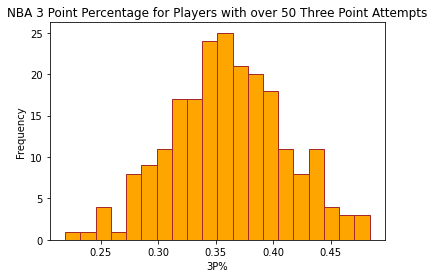

Average 3P%:  {36.058064516129036}


In [26]:
plt.hist(nba[nba['3PA']>50]['3P%'], facecolor='orange', edgecolor='brown', bins=20)
plt.title('NBA 3 Point Percentage for Players with over 50 Three Point Attempts')
plt.xlabel('3P%')
plt.ylabel('Frequency')
plt.show()
print(f'Average 3P%: ', {nba[nba['3PA']>50]['3P%'].mean()*100})

# Machine Learning

In this section, I will build a machine learning classification model to try to predict which position a player plays based on their player statistics. I begin by dropping unncessary columns to reduce noise from the data. For example, age should not have any effect on which position a player plays. Additionally, I will remove shot percentages in favor or shot attempts and shots made (For example, I will drop 3P% and keep 3P and 3PA).  I will also drop Offensive Rebounds (ORB) and Defensive Rebounds (DRB) and keep Total Rebounds (TRB)

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [28]:
nba['BLKpg']=nba['BLK']/nba['G']
nba['PFpg']=nba['PF']/nba['G']
nba['TOVpg']=nba['TOV']/nba['G']

In [29]:
ml_df = nba[['PPG', 'TRBpg', 'ASTpg', 'BLKpg', 'TOVpg', 'PFpg',
             'total_height_in', 'weight_lbs', 'Pos']]

In [30]:
X = ml_df.iloc[:, :-1]
y = ml_df.iloc[:, -1:]

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.30)

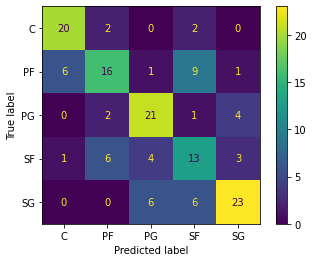

Decision Tree Classifier Accuracy Score:  0.6326530612244898


In [32]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

predictions = dtc.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=dtc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=dtc.classes_)
acc = acc = accuracy_score(y_test, predictions)
disp.plot()
plt.show()
print('Decision Tree Classifier Accuracy Score: ', acc)

/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


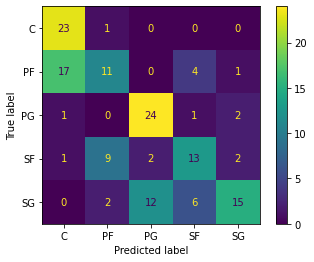

K Nearest Neighbor Classifier Accuracy Score:  0.5850340136054422


In [33]:
knc = KNeighborsClassifier(n_neighbors=2)
knc.fit(X_train, y_train)

predictions = knc.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=knc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=knc.classes_)
disp.plot()

plt.show()
acc = acc = accuracy_score(y_test, predictions)
print('K Nearest Neighbor Classifier Accuracy Score: ', acc)

<ipython-input-34-f971895f86c3>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)


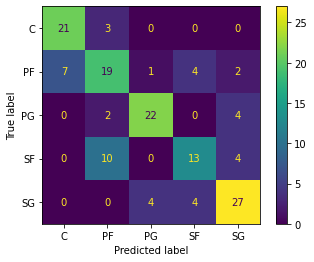

Random Forest Accuracy Score:  0.6938775510204082


In [34]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

predictions = rfc.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=rfc.classes_)
disp.plot()

plt.show()
acc = acc = accuracy_score(y_test, predictions)
print('Random Forest Accuracy Score: ', acc)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


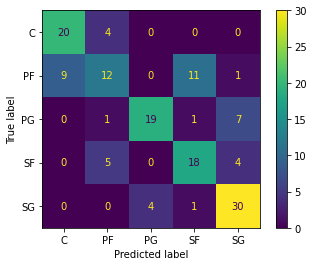

Gaussian Naive Bayes Accuracy Score:  0.673469387755102


In [35]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

predictions = gnb.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=gnb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=gnb.classes_)
disp.plot()
plt.show()
acc = acc = accuracy_score(y_test, predictions)
print('Gaussian Naive Bayes Accuracy Score: ', acc)

In [36]:
ml_df.corr()

,PPG,TRBpg,ASTpg,BLKpg,TOVpg,PFpg,total_height_in,weight_lbs
PPG,1.000000,0.652067,0.732429,0.361706,0.860664,0.596362,-0.061129,0.011305
TRBpg,0.652067,1.000000,0.416918,0.629130,0.618590,0.703189,0.382059,0.404232
ASTpg,0.732429,0.416918,1.000000,0.135759,0.823388,0.475669,-0.333781,-0.200207
BLKpg,0.361706,0.629130,0.135759,1.000000,0.319443,0.517685,0.412379,0.323549
TOVpg,0.860664,0.618590,0.823388,0.319443,1.000000,0.602712,-0.108676,-0.011472
PFpg,0.596362,0.703189,0.475669,0.517685,0.602712,1.000000,0.145818,0.193234
total_height_in,-0.061129,0.382059,-0.333781,0.412379,-0.108676,0.145818,1.000000,0.698327
weight_lbs,0.011305,0.404232,-0.200207,0.323549,-0.011472,0.193234,0.698327,1.000000


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


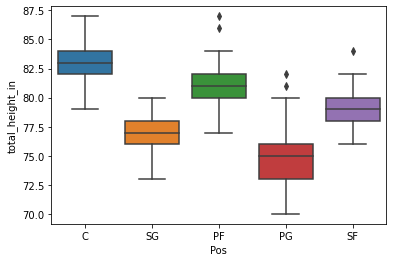

In [37]:
sns.boxplot(nba['Pos'], nba['total_height_in'])

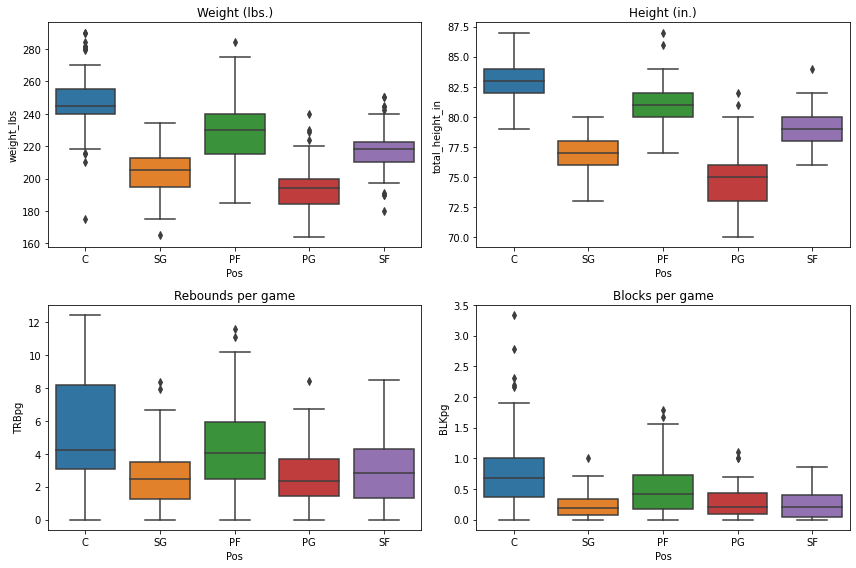

In [38]:
plt.figure(figsize=(12,8))

plt.subplot(2, 2, 1)
fig = sns.boxplot(data=nba, x='Pos', y='weight_lbs')
fig.set_title('Weight (lbs.)')


plt.subplot(2, 2, 2)
fig = sns.boxplot(data=nba, x='Pos', y='total_height_in')
fig.set_title('Height (in.)')

plt.subplot(2, 2, 3)
fig = sns.boxplot(data=nba, x='Pos', y='TRBpg')
fig.set_title('Rebounds per game')

plt.subplot(2, 2, 4)
fig = sns.boxplot(data=nba, x='Pos', y='BLKpg')
fig.set_title('Blocks per game')

plt.tight_layout()